In [1]:
import matplotlib.pyplot as plt
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import PancakeTrap

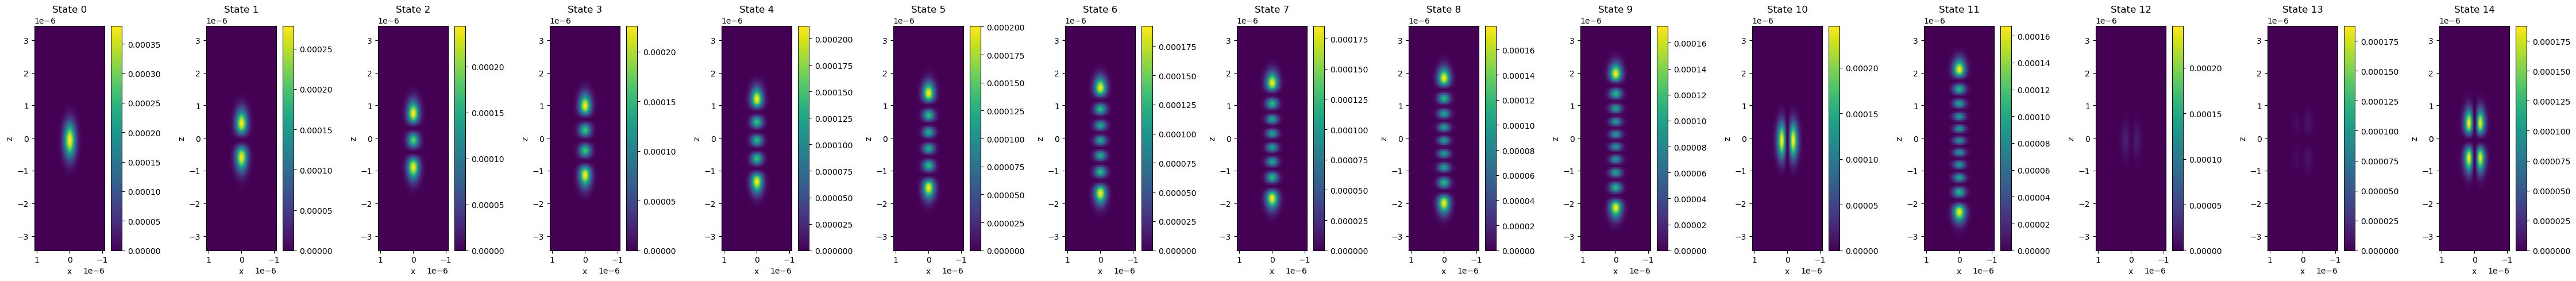

In [2]:
initial_power = 49 * si.uW 

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= -2.89 * si.G / si.cm,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer=1.08 * si.um,

    m= 161 * const.value("atomic mass constant"),
    mu_b= 9.93 * const.value("Bohr magneton" ),
    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 532 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

#### diagonalise

n_grid_1D = 100

n_pot_steps = [n_grid_1D,n_grid_1D,n_grid_1D]
n_levels = 15

left_cutoff = 1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
right_cutoff = -1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
back_cutoff = -1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
front_cutoff = 1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
bottom_cutoff = -0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh())),float(trap.subs(trap.get_tweezer_rayleigh()))])
top_cutoff = 0.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh())),float(trap.subs(trap.get_tweezer_rayleigh()))])
# left_cutoff = 0.3*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
# right_cutoff = -0.3*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
# back_cutoff = -0.3*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
# front_cutoff = 0.3*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
# bottom_cutoff = -0.2*np.max([float(trap.subs(trap.get_tweezer_rayleigh())),float(trap.subs(trap.get_tweezer_rayleigh()))])
# top_cutoff = 0.2*np.max([float(trap.subs(trap.get_tweezer_rayleigh())),float(trap.subs(trap.get_tweezer_rayleigh()))])

extend = [(left_cutoff,right_cutoff),
        (back_cutoff,front_cutoff),
        (bottom_cutoff,top_cutoff)]

energies, states, potential, coords = trap.nstationary_solution(
                        [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels,
                        method="matrix_free", export=False, )

x = coords[trap.x]
y = coords[trap.y]
z = coords[trap.z]
x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
pot = potential(x3D,y3D,z3D)


#### plot

n_states = 15

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(18/6*n_states, 5))  # Adjust the size as needed

# Loop over the state numbers from 0 to 5
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(np.abs(states[state_number, :, int(len(y)/2), :].T)**2, extent=[*extend[0], *extend[2]], origin="lower",
                   vmin=np.min(np.abs(states[state_number])**2), vmax=np.max(np.abs(states[state_number])**2))

    # Set labels for each subplot
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_title(f"State {state_number}")
    fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

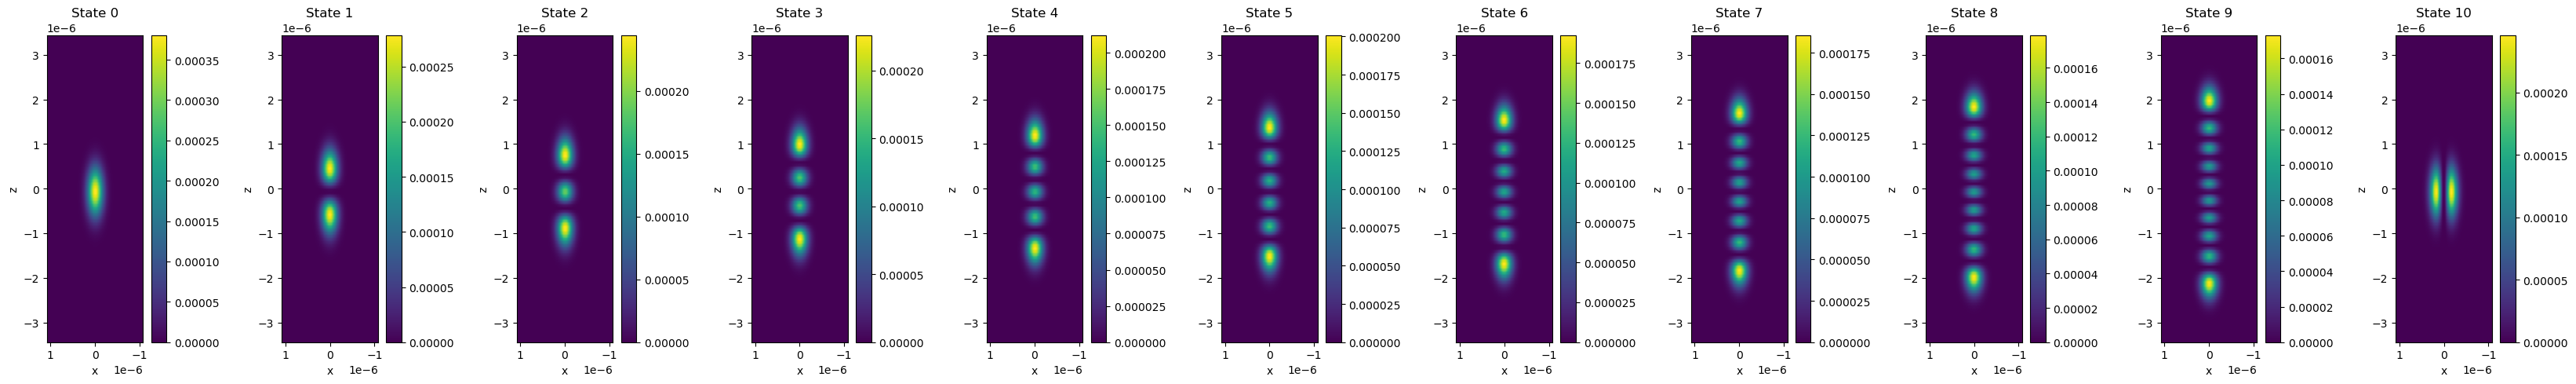

In [36]:
#### plot

n_states = 11

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(18/6*n_states, 5))  # Adjust the size as needed

# Loop over the state numbers from 0 to 5
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(np.abs(states[state_number, :, int(len(y)/2), :].T)**2, extent=[*extend[0], *extend[2]], origin="lower",
                   vmin=np.min(np.abs(states[state_number])**2), vmax=np.max(np.abs(states[state_number])**2))

    # Set labels for each subplot
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_title(f"State {state_number}")
    fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [4]:
print(f"{float(trap.subs(trap.get_omega_ax_tweezer()))/2/np.pi:.3f} Hz")
print(f"{trap.subs(trap.a *2*trap.power_tweezer/(np.pi*trap.waist_tweezer**2)/ const.k) /si.uK} µK")

244.368 Hz
1.08288036422384 µK


In [5]:
import matplotlib.pyplot as plt
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const
from scipy.optimize import minimize_scalar, curve_fit
from scipy import sparse

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer, TwoSiteLattice
from boson_helpers import *

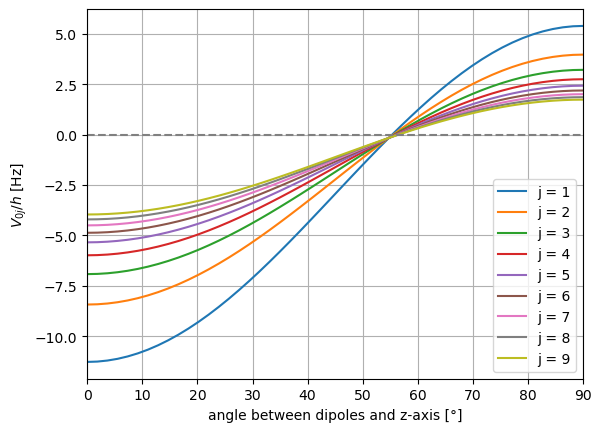

In [59]:
ind_1 = 0

V_lrs_max = 0

for j in range(1,10):    
    ind_2 = j

    #compute volume element
    dvol = np.array([])
    for coord in coords.values():
        dvol = np.append(dvol,np.abs(np.mean(np.diff(coord))))

    #compute interaction energies
    U_s = get_U_s(trap, states[ind_1], dvol)

    angles= np.deg2rad(np.linspace(0,90))
    U_dds = np.zeros_like(angles)
    V_lrs = np.zeros_like(angles)
    polarisations = np.zeros((len(angles),3))
    polarisations[:,0] = np.sin(angles)
    polarisations[:,2] = np.cos(angles)

    for i, pol in enumerate(polarisations):
        trap[trap.B_x] = pol[0]
        trap[trap.B_y] = pol[1]
        trap[trap.B_z] = pol[2]

        U_dds[i] = get_U_dd(trap, states[ind_1], dvol)
        V_lrs[i] = get_NNI(trap, states[ind_1], states[ind_2], dvol)

    V_lrs_max += V_lrs[0]
    plt.plot(np.rad2deg(angles), V_lrs/const.h, label=f"j = {j}")
plt.axhline(0, linestyle="dashed", color="grey")

plt.xlim(0,90)

plt.xlabel("angle between dipoles and z-axis [°]")
plt.ylabel(r"$V_{0j}/h$ [Hz]")

plt.grid()
plt.legend()

plt.savefig("NNI.png", dpi=300)
plt.show()

In [60]:
energies/const.h

array([-20300.06710322, -20069.67924244, -19841.26638092, -19614.82002624,
       -19390.33165075, -19167.79269105, -18947.19454576, -18728.52857117,
       -18511.78616692, -18296.95801305, -18212.12095438, -18084.03959135,
       -18212.12095404, -17993.98793879, -17993.9879383 ])

In [61]:
np.diff(energies)/const.h

array([ 2.30387861e+02,  2.28412862e+02,  2.26446355e+02,  2.24488375e+02,
        2.22538960e+02,  2.20598145e+02,  2.18665975e+02,  2.16742404e+02,
        2.14828154e+02,  8.48370587e+01,  1.28081363e+02, -1.28081363e+02,
        2.18133015e+02,  4.89512402e-07])

The maximum ratio of spacing and interaction between 0th and 1st excited state is:

In [62]:
np.diff(energies)[0]/const.h

230.3878607786473

In [63]:
V_lrs_max/const.h

-55.4863825353665

In [64]:
V_lrs_max/np.diff(energies)[0]

-0.24083900231478284

The dipolar interactions can be turned off entirely by choosing the following angle between magnetic field and z-axis:

In [65]:
np.rad2deg(angles[np.argmin(np.abs(np.abs(V_lrs)))])

56.93877551020409